In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import numpy as np
import pickle, itertools
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error
import shap
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

import utils

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 11})

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [79]:
# Flag to retrain models. If false, it will load models from 'final_output' folder
train = False

if train: # Store new info in a new folder (to not overwrite)
    output_file = './temp_output/'
else:
    output_file = './final_output/'

# Variable for plotting SHAP values - be aware that features could change due to randomness
plot_shap = False

# Set seed for reproducibility
seed = 10

# Section 1: Train dataset pre-processing

## 1.1 Data cleaning

### Load train data and fill missing hours

In [3]:
# Load the dataset
df = pd.read_csv('./data/illinois_basing_train.csv')

# Rename columns
df = df.rename(columns={'inj_diff\xa0': 'Target', 'SampleTimeUTC': 'Date'})

# Replace Target outliers and missing values in two columns
df.at[836, 'Target'] = 15
df.at[837, 'Target'] = 30
df.at[838, 'Target'] = -44.5
df.at[839, 'Target'] = -0.5

df.loc[834, 'Avg_PLT_CO2VentRate_TPH'] = 0
df.loc[835, 'Avg_PLT_CO2VentRate_TPH'] = 0
df.loc[836, 'Avg_PLT_CO2VentRate_TPH'] = 0

# Fill empty 'hourly dates'
df = df.dropna(subset='Target')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df = df.set_index('Date').sort_index()
date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')
df = df.reindex(date_range, fill_value=np.nan)
df.reset_index(inplace=True, drop=False)
df = df.rename(columns={'index': 'Date'})

# Fill nan values from missing dates using linear regression
new_row_indices = df[df['Target'].isnull()].index
df = utils.impute_missing_dates(df, new_row_indices)

### Create new target columns for classifier

In [4]:
# Create a new column for the absolute value of the target variable
df['Abs Target'] = np.abs(df['Target'])

# Create target for classifier
df['Target > 2'] = df['Abs Target'].apply(lambda x: 1 if x > 2 else 0)

In [5]:
# Drop feature that has many null values in test set
for col in df.columns:
    if '6945' in col:
        df = df.drop(col, axis=1)

## 1.2 Data imputation

### Impute values manually for the most important feature

In [6]:
# Find indices of missing values
nan_indices = np.where(df['Avg_CCS1_WHCO2InjPs_psi'].isna())[0]

# Find consecutive sequences of missing values
nan_seq = []
temp_seq = []
for i, idx in enumerate(nan_indices):
    if i == 0:
        temp_seq.append(idx)
    elif idx == nan_indices[i-1]+1:
        temp_seq.append(idx)
    else:
        nan_seq.append(temp_seq)
        temp_seq = [idx]
# add the last sequence
if temp_seq:
    nan_seq.append(temp_seq)

# Replace missing values in specific locations with specific values, derived from nearby values
df.loc[nan_seq[0], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[1], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[2], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[3], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.203125
df.loc[nan_seq[4], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.233507
df.loc[nan_seq[5], 'Avg_CCS1_WHCO2InjPs_psi'] = 1.03
df.loc[nan_seq[6], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[list(range(622,661)), 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[nan_seq[9], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[nan_seq[10], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2
df.loc[nan_seq[11], 'Avg_CCS1_WHCO2InjPs_psi'] = 0.2

### Impute the other columns to prepare for feature engineering

In [7]:
# Impute using K neighours found in the other notebook
imputer = KNNImputer(n_neighbors=4, weights='uniform')

# Split the data into predictor and target variables
y = df[['Date', 'Target', 'Abs Target', 'Target > 2']]
x = df.drop(['Date', 'Target', 'Abs Target', 'Target > 2'], axis=1)
cols = x.columns

# Fill missing values in the predictor variables
x = imputer.fit_transform(x)
x = pd.DataFrame(x, columns=cols)

# Section 2: Feature engineering

In [8]:
# Create temperature and pressure difference features
x = utils.get_temperature_diff_depth(x)
x = utils.get_pressure_diff_depth(x)

# Create a new feature by subtracting two existing features
x['Diff pressure downhole-wellhead'] = x['Avg_CCS1_DH6325Ps_psi'] - x['Avg_CCS1_ANPs_psi']

# Save column names and create lag features
cols = x.columns
lagged_df = utils.create_lag_features(x, features=cols, n_lags=5)

# Create additional features using functions from the utils module
x = utils.create_abs_features(x, x.columns)
x = utils.create_trend_features(x, x.columns)

# Replace infinite values with NaN
lagged_df = lagged_df.replace([np.inf, -np.inf], np.nan)

# Concatenate original DataFrame, lagged DataFrame, and target variables
df = pd.concat([x, lagged_df, y], axis=1)

# Remove first 5 data points due to lagged features
df = df.drop(df.index[:5])

# Section 3: Classifier

## 3.1 Feature selection

In [9]:
# Extract the target variable from the dataset
y_train = df['Target > 2']
# Drop unnecessary columns and keep the feature matrix
x_train = df.drop(['Date', 'Target', 'Abs Target', 'Target > 2'], axis=1)

In [10]:
# Split the data into training, validation, and test sets using a 60-20-20 split
X_train1, X_val1, y_train1, y_val1 = train_test_split(x_train, y_train, test_size=0.4, shuffle=False)
X_val1, _, y_val1, _ = train_test_split(X_val1, y_val1, test_size=0.5, shuffle=False)

# Drop the first 5 rows of validation set to avoid leakage from lagged features
X_val1 = X_val1.iloc[5:]
y_val1 = y_val1.iloc[5:]

# Create XGBoost DMatrix objects for training and validation data
dtrain1 = xgb.DMatrix(X_train1, y_train1)
dval1 = xgb.DMatrix(X_val1, y_val1)

In [11]:
# Define the hyperparameters for the XGBoost model
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['logloss'],
          'lambda': 1, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'seed':seed}

# Train the XGBoost model
clf = xgb.train(params,dtrain1,evals=[(dtrain1, 'train'),(dval1, 'test')],num_boost_round=1000,verbose_eval=True,early_stopping_rounds=10)

[0]	train-logloss:0.64766	test-logloss:0.64689
[1]	train-logloss:0.60645	test-logloss:0.60498
[2]	train-logloss:0.56893	test-logloss:0.56689
[3]	train-logloss:0.53465	test-logloss:0.53235
[4]	train-logloss:0.50338	test-logloss:0.50054
[5]	train-logloss:0.47459	test-logloss:0.47131
[6]	train-logloss:0.44804	test-logloss:0.44442
[7]	train-logloss:0.42345	test-logloss:0.41928
[8]	train-logloss:0.40076	test-logloss:0.39615
[9]	train-logloss:0.37965	test-logloss:0.37494
[10]	train-logloss:0.36004	test-logloss:0.35497
[11]	train-logloss:0.34191	test-logloss:0.33641
[12]	train-logloss:0.32494	test-logloss:0.31907
[13]	train-logloss:0.30908	test-logloss:0.30286
[14]	train-logloss:0.29416	test-logloss:0.28770
[15]	train-logloss:0.28027	test-logloss:0.27352
[16]	train-logloss:0.26740	test-logloss:0.26050
[17]	train-logloss:0.25515	test-logloss:0.24795
[18]	train-logloss:0.24372	test-logloss:0.23635
[19]	train-logloss:0.23296	test-logloss:0.22532
[20]	train-logloss:0.22293	test-logloss:0.21505
[2

In [12]:
# Make predictions on training and validation data
y_pred_train1 = clf.predict(dtrain1)
y_pred_val1 = clf.predict(dval1)

In [13]:
# Feature importance analysis using 'gain' method
feat_importance = clf.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

# Feature importance analysis using 'weight' method
feat_importance = clf.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Feature importance analysis using SHAP values
explainer = shap.TreeExplainer(clf)
shap_values = explainer(X_train1)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train1.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

# Combine the top features from each importance analysis method
clf_top_K_feats = set(top_10_gain+top_10_weight+top_10_shap)

In [14]:
if train:
    # Saving the top K features
    with open(output_file+"classifier/clf_top_K_feats.pkl", "wb") as f:
        pickle.dump(clf_top_K_feats, f)
else:
    with open(output_file+"classifier/clf_top_K_feats.pkl", 'rb') as f:
        clf_top_K_feats = list(pickle.load(f))

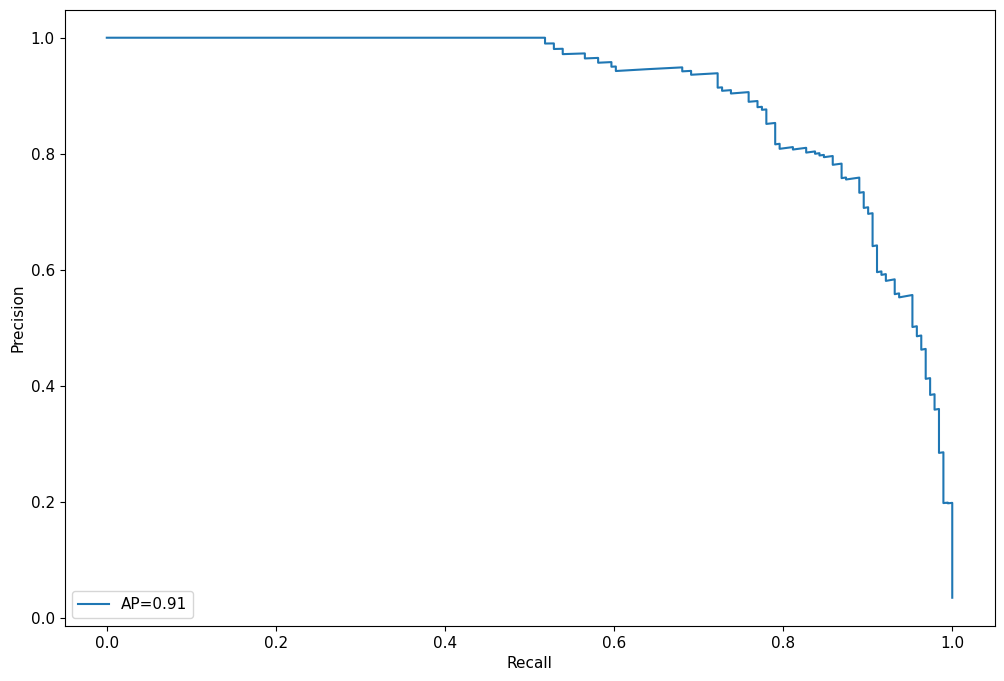

In [15]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val1, y_pred_val1)
average_precision = average_precision_score(y_val1, y_pred_val1)
plt.plot(recall, precision, label='AP={:.2f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [16]:
# calculate the precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_val1, y_pred_val1)
area = auc(recall, precision)

# find the threshold that maximizes the AUC-PR
f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
best_threshold = thresholds[np.argmax(f1_scores)]

# print the best threshold and the corresponding AUC-PR
print('Best Threshold: {:.4f}'.format(best_threshold))

Best Threshold: 0.4736


In [17]:
# predict binary labels using the best threshold
y_pred = (y_pred_val1 >= best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val1, y_pred)
cm

array([[5281,   15],
       [  46,  145]], dtype=int64)

# 3.2 Hyperparameter tuning

In [18]:
# Keep only the best X features
x_train = x_train[list(clf_top_K_feats)]

In [19]:
# Split the data into training and validation sets (80/20 split)
X_train2, X_val2, y_train2, y_val2 = train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# Drop the first 5 rows of the validation set to avoid leakage from lagged features
X_val2 = X_val2.iloc[5:]
y_val2 = y_val2.iloc[5:]

# Create XGBoost DMatrix objects for training and validation data
dtrain2 = xgb.DMatrix(X_train2, y_train2)
dval2 = xgb.DMatrix(X_val2, y_val2)

In [20]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'eval_metric': ['logloss'],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['binary:logistic'],
    'scale_pos_weight': [1, np.sqrt(sum(y_train==0)/sum(y_train==1))],
    'seed': [seed]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [21]:
# Initialize empty lists to store results
auc_scores = []
aucpr_scores = []
best_thresholds = []
confusion_matrices = []
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    clf = xgb.train(hyperparams,dtrain2,evals=[(dtrain2, 'train'),(dval2, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=15)

    # Make predictions on the test set
    y_pred_val2 = clf.predict(dval2)

    num_trees = clf.best_ntree_limit
    num_trees_list.append(num_trees)

    # Calculate the precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_val2, y_pred_val2)
    
    # Calculate AUC and AUCPR
    print(f'AUC={auc(recall, precision)}')
    print(f'AUCPR={average_precision_score(y_val2, y_pred_val2)}')
    auc_scores.append(auc(recall, precision))
    aucpr_scores.append(average_precision_score(y_val2, y_pred_val2))

    # Find the best threshold
    f1_scores = 2 * precision * recall / (precision + recall + 1e-10)
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_thresholds.append(best_threshold)

    # Calculate TP, FP, FN using the best threshold
    y_pred2 = (y_pred_val2 > best_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_val2, y_pred2).ravel()
    confusion_matrices.append((tp, fp, fn))
    print(f'TP={tp}, FP={fp}, FN={fn}')

    print('--'*5)

# Combine the results into a list of dictionaries
clf_results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    clf_results.append({
        'hyperparameters': hyperparams,
        'AUC': auc_scores[i],
        'AUCPR': aucpr_scores[i],
        'Best_threshold': best_thresholds[i],
        'TP': confusion_matrices[i][0],
        'FP': confusion_matrices[i][1],
        'FN': confusion_matrices[i][2],
        'FP+FN': confusion_matrices[i][1]+confusion_matrices[i][2],
    })

AUC=0.9657047912205514
AUCPR=0.9658763121882357
TP=172, FP=12, FN=16
----------
AUC=0.9638973723185386
AUCPR=0.9641059191652209
TP=179, FP=17, FN=9
----------
AUC=0.9569800159448085
AUCPR=0.9573483446375555
TP=181, FP=22, FN=7
----------
AUC=0.9590715223056042
AUCPR=0.9593621449108731
TP=173, FP=12, FN=15
----------
AUC=0.9574249017651434
AUCPR=0.9580090259800607
TP=174, FP=14, FN=14
----------
AUC=0.9623468783263736
AUCPR=0.9625859455368999
TP=176, FP=17, FN=12
----------
AUC=0.9617593099064824
AUCPR=0.9620315152007292
TP=173, FP=14, FN=15
----------
AUC=0.9581657225934758
AUCPR=0.9585037289874635
TP=176, FP=15, FN=12
----------
AUC=0.9570440018082292
AUCPR=0.9574884632825561
TP=177, FP=19, FN=11
----------
AUC=0.9635977625014717
AUCPR=0.9638038576941523
TP=170, FP=10, FN=18
----------
AUC=0.959411534097739
AUCPR=0.9596515486574237
TP=173, FP=16, FN=15
----------
AUC=0.9514937123620066
AUCPR=0.9521247273147181
TP=174, FP=14, FN=14
----------
AUC=0.9637169268337188
AUCPR=0.963941646620

### Get best results

In [22]:
if train:
    # Find the best hyperparameters based on the highest AUCPR
    clf_best_idx = np.argmax([x['AUCPR'] for x in clf_results])

    # Get the best threshold, hyperparameters, and optimal number of trees
    clf_best_threshold = clf_results[clf_best_idx]['Best_threshold']
    clf_best_hyperparams = clf_results[clf_best_idx]['hyperparameters']
    clf_opt_num_trees = num_trees_list[clf_best_idx]

    print(clf_results[clf_best_idx])
    print(f'Num of trees: {clf_opt_num_trees}')
else:
    clf_best_hyperparams = {'alpha': 1, 'lambda': 5, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 0.7, 'eval_metric': 'logloss', 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 4.909044743379772, 'seed': 0}
    clf_best_threshold = 0.56767243
    clf_opt_num_trees = 547

{'hyperparameters': {'alpha': 1, 'lambda': 5, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 0.7, 'eval_metric': 'logloss', 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'binary:logistic', 'scale_pos_weight': 4.909044743379772, 'seed': 0}, 'AUC': 0.9659773207432155, 'AUCPR': 0.9661804927372256, 'Best_threshold': 0.56767243, 'TP': 175, 'FP': 13, 'FN': 13, 'FP+FN': 26}
Num of trees: 547


In [23]:
# Retrain with best parameters
clf = xgb.train(clf_best_hyperparams, dtrain2, evals=[(dtrain2,'train'),(dval2,'test')], num_boost_round=clf_opt_num_trees)

[0]	train-logloss:0.64966	test-logloss:0.64838
[1]	train-logloss:0.60999	test-logloss:0.60779
[2]	train-logloss:0.57474	test-logloss:0.57144
[3]	train-logloss:0.54181	test-logloss:0.53759
[4]	train-logloss:0.51151	test-logloss:0.50633
[5]	train-logloss:0.48422	test-logloss:0.47779
[6]	train-logloss:0.45869	test-logloss:0.45151
[7]	train-logloss:0.43498	test-logloss:0.42724
[8]	train-logloss:0.41314	test-logloss:0.40444
[9]	train-logloss:0.39262	test-logloss:0.38311
[10]	train-logloss:0.37352	test-logloss:0.36338
[11]	train-logloss:0.35561	test-logloss:0.34496
[12]	train-logloss:0.33927	test-logloss:0.32768
[13]	train-logloss:0.32367	test-logloss:0.31153
[14]	train-logloss:0.30949	test-logloss:0.29655
[15]	train-logloss:0.29597	test-logloss:0.28268
[16]	train-logloss:0.28313	test-logloss:0.26937
[17]	train-logloss:0.27115	test-logloss:0.25694
[18]	train-logloss:0.25994	test-logloss:0.24537
[19]	train-logloss:0.24966	test-logloss:0.23457
[20]	train-logloss:0.23969	test-logloss:0.22420
[2

In [24]:
# Make predictions on training and validation data
y_pred_train2 = clf.predict(dtrain2)
y_pred_val2 = clf.predict(dval2)

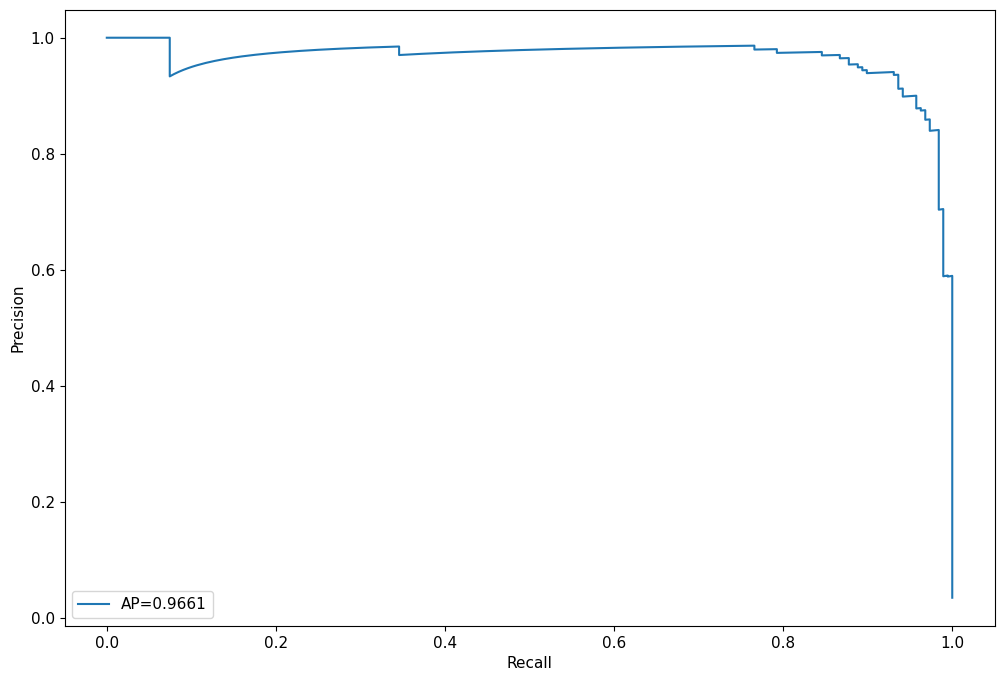

In [25]:
# calculate and plot the AUC-PR curve
precision, recall, _ = precision_recall_curve(y_val2, y_pred_val2)
average_precision = average_precision_score(y_val2, y_pred_val2)
plt.plot(recall, precision, label='AP={:.4f}'.format(average_precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower left')
plt.show()

In [26]:
# predict binary labels using the best threshold
y_pred2 = (y_pred_val2 >= clf_best_threshold).astype(int)

# calculate the confusion matrix
cm = confusion_matrix(y_val2, y_pred2)
cm

array([[5286,   13],
       [  12,  176]], dtype=int64)

### Plot classifier's SHAP values
Please note that the list below could change due to the random nature of the algorithm

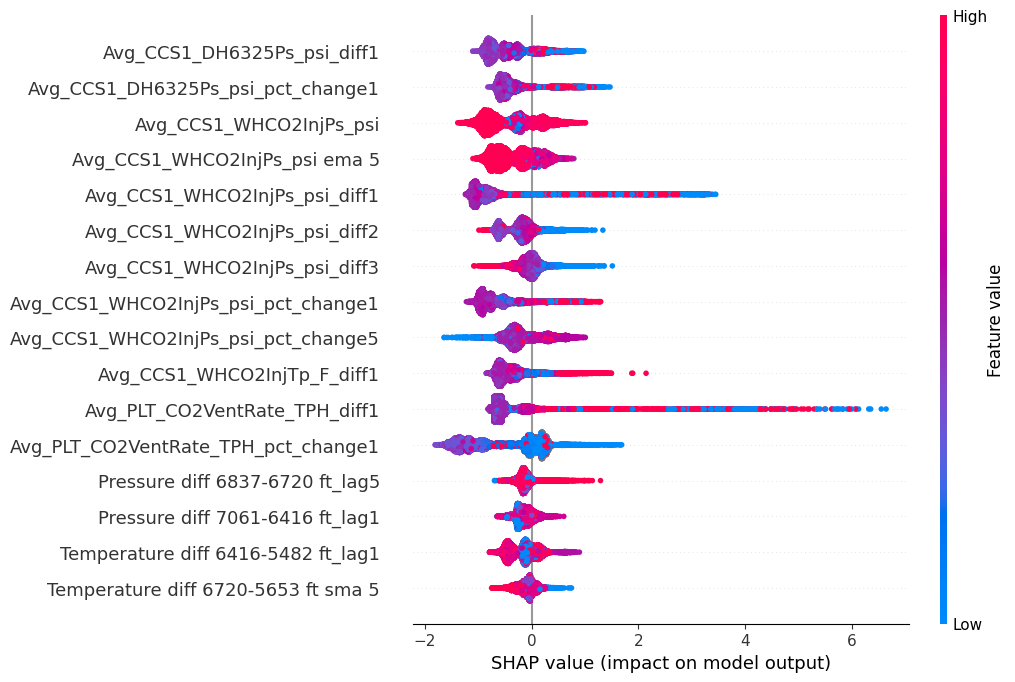

In [80]:
if plot_shap:
    # Rearrange features to group them in image
    cols = [
        'Avg_CCS1_DH6325Ps_psi_diff1',
        'Avg_CCS1_DH6325Ps_psi_pct_change1',
        'Avg_CCS1_WHCO2InjPs_psi',
        'Avg_CCS1_WHCO2InjPs_psi ema 5',
        'Avg_CCS1_WHCO2InjPs_psi_diff1',
        'Avg_CCS1_WHCO2InjPs_psi_diff2',
        'Avg_CCS1_WHCO2InjPs_psi_diff3',
        'Avg_CCS1_WHCO2InjPs_psi_pct_change1',
        'Avg_CCS1_WHCO2InjPs_psi_pct_change5',
        'Avg_CCS1_WHCO2InjTp_F_diff1',
        'Avg_PLT_CO2VentRate_TPH_diff1',
        'Avg_PLT_CO2VentRate_TPH_pct_change1',
        'Pressure diff 6837-6720 ft_lag5',
        'Pressure diff 7061-6416 ft_lag1',
        'Temperature diff 6416-5482 ft_lag1',
        'Temperature diff 6720-5653 ft sma 5'
    ]

    # Calculate shap values
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X_train2)

    order = X_train2[cols]
    col2num = {col: i for i, col in enumerate(X_train2.columns)}
    order = list(map(col2num.get, order))

    shap.plots.beeswarm(shap_values, show=False, color_bar=True, order=order, max_display=16)
    plt.show()

## 3.3 Retrain classifier with all available data

In [28]:
# Keep only the best X features
x_train = x_train[list(clf_top_K_feats)]
dfull = xgb.DMatrix(x_train, y_train)

In [29]:
if train:
    # Retrain the model with the best hyperparameters using all available data
    final_clf = xgb.train(clf_best_hyperparams, dfull, num_boost_round=int(clf_opt_num_trees*1.09))
    final_clf.save_model(output_file+"classifier/xgb_final_clf.json")
else:
    # Load pre-trained model
    final_clf = xgb.Booster()
    final_clf.load_model(output_file+"classifier/xgb_final_clf.json")
    dfull = xgb.DMatrix(x_train[final_clf.feature_names], y_train)

In [30]:
y_pred_train = final_clf.predict(dfull)
y_pred_train = (y_pred_train >= clf_best_threshold).astype(int)

# Section 4: Spikes regressor

## 4.1 Feature selection

In [86]:
# Append output of the classifier
df['Classifier output'] = y_pred_train

# Only keep data point classified as positive
y_train = df[df['Classifier output']==1]['Target']
x_train = df[df['Classifier output']==1].drop(['Date', 'Target','Abs Target', 'Target > 2', 'Classifier output'], axis=1)

# Splitting the train and validation datasets
X_train3, X_val3, y_train3, y_val3 = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val3, _, y_val3, _ = train_test_split(X_val3, y_val3, test_size=0.66, shuffle=False)

# Dropping the first 5 rows from validation dataset due to lagged features
X_val3 = X_val3.iloc[5:]
y_val3 = y_val3.iloc[5:]

In [33]:
# Defining XGBoost model semi-optimized hyperparams
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0, 'seed': seed}

dtrain = xgb.DMatrix(X_train3, y_train3)
dval = xgb.DMatrix(X_val3, y_val3)

# Training the XGBoost model on train and validation datasets
spikes_reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:16.25466	test-rmse:19.24137
[1]	train-rmse:15.68087	test-rmse:18.64130
[2]	train-rmse:15.10755	test-rmse:18.06130
[3]	train-rmse:14.57425	test-rmse:17.42699
[4]	train-rmse:14.11328	test-rmse:16.81299
[5]	train-rmse:13.63042	test-rmse:16.29342
[6]	train-rmse:13.17651	test-rmse:15.81954
[7]	train-rmse:12.77146	test-rmse:15.32464
[8]	train-rmse:12.36317	test-rmse:14.84346
[9]	train-rmse:11.95335	test-rmse:14.40130
[10]	train-rmse:11.59350	test-rmse:13.99064
[11]	train-rmse:11.24650	test-rmse:13.56139
[12]	train-rmse:10.91718	test-rmse:13.23202
[13]	train-rmse:10.56724	test-rmse:12.83866
[14]	train-rmse:10.28088	test-rmse:12.55176
[15]	train-rmse:9.99984	test-rmse:12.26752
[16]	train-rmse:9.73850	test-rmse:12.01655
[17]	train-rmse:9.47382	test-rmse:11.81174
[18]	train-rmse:9.22230	test-rmse:11.56703
[19]	train-rmse:8.99018	test-rmse:11.34827
[20]	train-rmse:8.77581	test-rmse:11.09859
[21]	train-rmse:8.57416	test-rmse:10.87664
[22]	train-rmse:8.34952	test-rmse:10.71021
[23]	t

In [34]:
# Predicting the target values on train and validation datasets
y_pred_train3 = spikes_reg.predict(dtrain)
y_pred_val3 = spikes_reg.predict(dval)

# Getting feature importance using GAIN and WEIGHT methods
feat_importance = spikes_reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = spikes_reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Getting top 10 SHAP values
explainer = shap.TreeExplainer(spikes_reg)
shap_values = explainer(X_train3)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train3.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

spikes_reg_top_K_feats = list(set(top_10_gain+top_10_weight+top_10_shap))

In [35]:
if train:
    # Saving the top K features
    with open(output_file+"regressor_class1/spikes_reg_top_K_feats.pkl", "wb") as f:
        pickle.dump(spikes_reg_top_K_feats, f)
else:
    with open(output_file+"regressor_class1/spikes_reg_top_K_feats.pkl", 'rb') as f:
        spikes_reg_top_K_feats = list(pickle.load(f))

## 4.2 Hyperparameter tuning

In [36]:
# Split the dataset into train, validation and test sets
X_train4, X_val4, y_train4, y_val4 = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val4, _, y_val4, _ = train_test_split(X_val4, y_val4, test_size=0.5, shuffle=False)

# Remove the first 5 rows from the validation set due to lagged values
X_val4 = X_val4.iloc[5:]
y_val4 = y_val4.iloc[5:]

In [38]:
3 # Create DMatrix objects for the train and validation sets
dtrain = xgb.DMatrix(X_train4[spikes_reg_top_K_feats], y_train4)
dval = xgb.DMatrix(X_val4[spikes_reg_top_K_feats], y_val4)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
    'seed': [seed]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [39]:
# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

# Iterate over all hyperparameter combinations and train and evaluate the XGBoost model on the validation set
for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    spikes_reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train4 = spikes_reg.predict(dtrain)
    y_pred_val4 = spikes_reg.predict(dval)

    num_trees = spikes_reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val4, y_pred_val4))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_val4, y_pred_val4, sample_weight=np.abs(y_val4)/sum(np.abs(y_val4)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

    print('--'*5)
    
# Combine the results into a list of dictionaries
spikes_results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    spikes_results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 7.49
MAPE: 0.32%
----------
RMSE: 7.09
MAPE: 0.29%
----------
RMSE: 7.52
MAPE: 0.32%
----------
RMSE: 7.08
MAPE: 0.30%
----------
RMSE: 7.51
MAPE: 0.32%
----------
RMSE: 7.25
MAPE: 0.30%
----------
RMSE: 7.62
MAPE: 0.32%
----------
RMSE: 7.37
MAPE: 0.31%
----------
RMSE: 7.73
MAPE: 0.33%
----------
RMSE: 7.42
MAPE: 0.31%
----------
RMSE: 7.59
MAPE: 0.32%
----------
RMSE: 7.48
MAPE: 0.31%
----------
RMSE: 7.62
MAPE: 0.31%
----------
RMSE: 7.45
MAPE: 0.30%
----------
RMSE: 7.62
MAPE: 0.32%
----------
RMSE: 7.40
MAPE: 0.30%
----------
RMSE: 7.44
MAPE: 0.32%
----------
RMSE: 7.19
MAPE: 0.29%
----------
RMSE: 7.47
MAPE: 0.31%
----------
RMSE: 7.34
MAPE: 0.30%
----------
RMSE: 7.63
MAPE: 0.32%
----------
RMSE: 7.33
MAPE: 0.29%
----------
RMSE: 7.57
MAPE: 0.32%
----------
RMSE: 7.43
MAPE: 0.31%
----------
RMSE: 7.75
MAPE: 0.33%
----------
RMSE: 7.40
MAPE: 0.30%
----------
RMSE: 7.72
MAPE: 0.32%
----------
RMSE: 7.35
MAPE: 0.29%
----------
RMSE: 7.77
MAPE: 0.32%
----------
RMSE: 7.46
MAP

In [40]:
if train:
    # Find the best hyperparameters based on the lowest rmse
    spikes_best_idx = np.argmin([x['RMSE'] for x in spikes_results])

    # Get the best threshold, hyperparameters, and optimal number of trees
    spikes_best_hyperparams = spikes_results[spikes_best_idx]['hyperparameters']
    spikes_opt_num_trees = num_trees_list[spikes_best_idx]

    print(spikes_results[spikes_best_idx])
    print(f'Num of trees: {spikes_opt_num_trees}')
else:
    spikes_best_hyperparams = {'alpha': 1, 'lambda': 1, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'seed': 0}
    spikes_opt_num_trees = 126

{'hyperparameters': {'alpha': 1, 'lambda': 1, 'colsample_bytree': 0.7, 'colsample_bylevel': 1, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'seed': 0}, 'RMSE': 7.07973844286487, 'MAPE': 0.2982130721229665}
Num of trees: 126


### Test regressor in the final 15%

In [87]:
X_train4, X_test4, y_train4, y_test4 = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

# Removing first 5 rows of test set and corresponding labels due to lagged features
X_test4 = X_test4.iloc[5:]
y_test4 = y_test4.iloc[5:]

dtrain = xgb.DMatrix(X_train4[spikes_reg_top_K_feats], y_train4)
dval = xgb.DMatrix(X_test4[spikes_reg_top_K_feats], y_test4)

# Training the final model on best hyperparameters and optimal number of trees
spikes_reg = xgb.train(spikes_best_hyperparams,dtrain,num_boost_round=int(spikes_opt_num_trees*1.09))

In [42]:
# Predicting on the validation set
preds_reg = spikes_reg.predict(dval)
rmse_class_1 = np.sqrt(mean_squared_error(y_test4, preds_reg))
rmse_class_1

6.288952357649355

In [43]:
# Calculating the mean absolute percentage error for class 1
MAPE_class_1 = mean_absolute_percentage_error(y_test4, preds_reg, sample_weight=np.abs(y_test4/sum(np.abs(y_test4))))
MAPE_class_1

0.2855778906980867

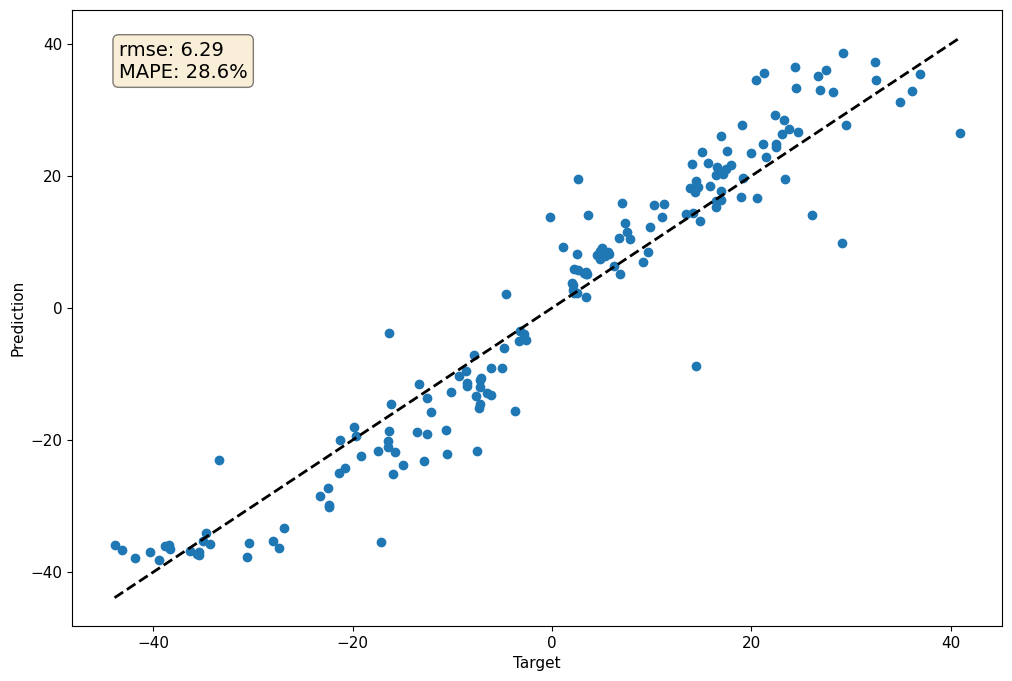

In [44]:
plt.scatter(y_test4, preds_reg)
textstr = 'rmse: ' + format(rmse_class_1, '.3g') +'\n' + 'MAPE: ' + format(100 * MAPE_class_1, '.3g') + '%'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

# Add a diagonal line
min_value = min(y_test4.min(), preds_reg.min())
max_value = max(y_test4.max(), preds_reg.max())
plt.plot([min_value, max_value], [min_value, max_value], 'k--', lw=2)

plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.show()

### Plot regressor's SHAP values
Please note that the list below could change due to the random nature of the algorithm

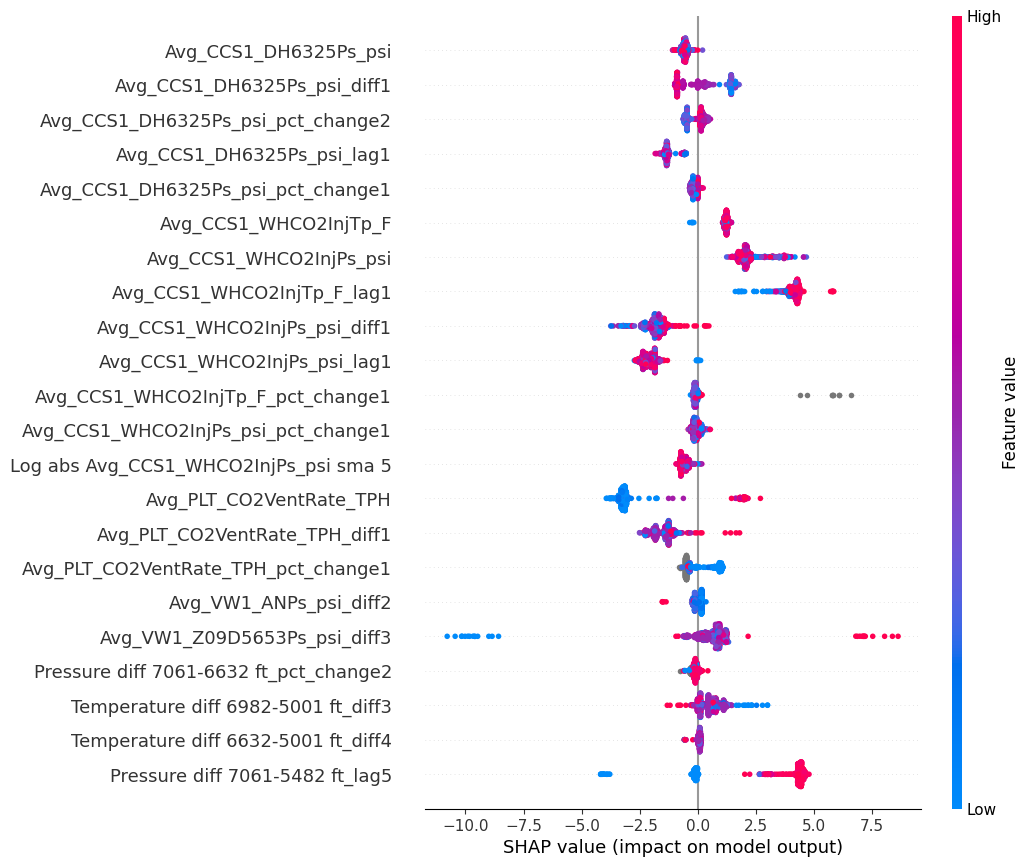

In [89]:
if plot_shap:
    # Reordering columns for the SHAP plot
    cols = [
        'Avg_CCS1_DH6325Ps_psi',
        'Avg_CCS1_DH6325Ps_psi_diff1',
        'Avg_CCS1_DH6325Ps_psi_pct_change2',
        'Avg_CCS1_DH6325Ps_psi_lag1',
        'Avg_CCS1_DH6325Ps_psi_pct_change1',

        'Avg_CCS1_WHCO2InjTp_F',
        'Avg_CCS1_WHCO2InjPs_psi',
        'Avg_CCS1_WHCO2InjTp_F_lag1',
        'Avg_CCS1_WHCO2InjPs_psi_diff1',
        'Avg_CCS1_WHCO2InjPs_psi_lag1',
        'Avg_CCS1_WHCO2InjTp_F_pct_change1',
        'Avg_CCS1_WHCO2InjPs_psi_pct_change1',
        'Log abs Avg_CCS1_WHCO2InjPs_psi sma 5',

        'Avg_PLT_CO2VentRate_TPH',
        'Avg_PLT_CO2VentRate_TPH_diff1',
        'Avg_PLT_CO2VentRate_TPH_pct_change1',

        'Avg_VW1_ANPs_psi_diff2',
        'Avg_VW1_Z09D5653Ps_psi_diff3',

        'Pressure diff 7061-6632 ft_pct_change2',
        'Temperature diff 6982-5001 ft_diff3',
        'Temperature diff 6632-5001 ft_diff4',
        'Pressure diff 7061-5482 ft_lag5'
    ]

    X_train4 = X_train4[cols]

    # Calculate shap values
    explainer = shap.TreeExplainer(spikes_reg)
    shap_values = explainer(X_train4)

    # Ordering the columns for the SHAP plot
    order = X_train4.columns
    col2num = {col: i for i, col in enumerate(X_train4)}
    order = list(map(col2num.get, order))

    # Plotting the SHAP values
    shap.plots.beeswarm(shap_values, max_display=len(cols), show=False, color_bar=True, order=order)
    plt.show()

# 4.3 Retrain final spike regressor with 100% of the train data

In [47]:
y_train = df[df['Classifier output']==1]['Target']
x_train = df[df['Classifier output']==1][spikes_reg_top_K_feats]

dtrain = xgb.DMatrix(x_train, y_train)

if train:
    final_spikes_reg = xgb.train(spikes_best_hyperparams, dtrain, num_boost_round=int(spikes_opt_num_trees*1.09))
    final_spikes_reg.save_model(output_file+"regressor_class1/positive_class_xgb_final_regressor.json")

else:
    # Load pre-trained model
    final_spikes_reg = xgb.Booster()
    final_spikes_reg.load_model(output_file+"regressor_class1/positive_class_xgb_final_regressor.json")

# Secion 5: Low-values regressor

## 5.1 Feature selection

In [48]:
# Only keep data point classified as positive
y_train = df[df['Target > 2']==0]['Target']
x_train = df[df['Target > 2']==0].drop(['Date', 'Target','Abs Target', 'Target > 2', 'Classifier output'], axis=1)

# Splitting the train and validation datasets
X_train5, X_val5, y_train5, y_val5 = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val5, _, y_val5, _ = train_test_split(X_val5, y_val5, test_size=0.66, shuffle=False)

# Dropping the first 5 rows from validation dataset due to lagged features
X_val5 = X_val5.iloc[5:]
y_val5 = y_val5.iloc[5:]

In [49]:
# Defining XGBoost model semi-optimized hyperparams
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0, 'seed': seed}

dtrain = xgb.DMatrix(X_train5, y_train5)
dval = xgb.DMatrix(X_val5, y_val5)

# Training the XGBoost model on train and validation datasets
low_values_reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=500,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:0.29613	test-rmse:0.22933
[1]	train-rmse:0.29328	test-rmse:0.22775
[2]	train-rmse:0.29074	test-rmse:0.22622
[3]	train-rmse:0.28820	test-rmse:0.22452
[4]	train-rmse:0.28595	test-rmse:0.22357
[5]	train-rmse:0.28381	test-rmse:0.22147
[6]	train-rmse:0.28187	test-rmse:0.22017
[7]	train-rmse:0.27991	test-rmse:0.21901
[8]	train-rmse:0.27815	test-rmse:0.21863
[9]	train-rmse:0.27646	test-rmse:0.21758
[10]	train-rmse:0.27491	test-rmse:0.21649
[11]	train-rmse:0.27298	test-rmse:0.21538
[12]	train-rmse:0.27137	test-rmse:0.21435
[13]	train-rmse:0.27006	test-rmse:0.21313
[14]	train-rmse:0.26873	test-rmse:0.21218
[15]	train-rmse:0.26764	test-rmse:0.21139
[16]	train-rmse:0.26629	test-rmse:0.21078
[17]	train-rmse:0.26517	test-rmse:0.21036
[18]	train-rmse:0.26414	test-rmse:0.20980
[19]	train-rmse:0.26285	test-rmse:0.20916
[20]	train-rmse:0.26150	test-rmse:0.20877
[21]	train-rmse:0.26015	test-rmse:0.20826
[22]	train-rmse:0.25938	test-rmse:0.20777
[23]	train-rmse:0.25814	test-rmse:0.20699
[2

In [50]:
# Predicting the target values on train and validation datasets
y_pred_train5 = low_values_reg.predict(dtrain)
y_pred_val5 = low_values_reg.predict(dval)

# Getting feature importance using GAIN and WEIGHT methods
feat_importance = low_values_reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = low_values_reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

# Getting top 10 SHAP values
explainer = shap.TreeExplainer(low_values_reg)
shap_values = explainer(X_train3)
shap_summary = pd.DataFrame(shap_values.values, columns=X_train3.columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

low_values_reg_top_K_feats = list(set(top_10_gain+top_10_weight+top_10_shap))

In [51]:
if train:
    # Saving the top K features
    with open(output_file+"regressor_class0/low_values_reg_top_K_feats.pkl", "wb") as f:
        pickle.dump(low_values_reg_top_K_feats, f)
else:
    with open(output_file+"regressor_class0/low_values_reg_top_K_feats.pkl", 'rb') as f:
        low_values_reg_top_K_feats = list(pickle.load(f))

## 5.2 Hyperparameter tuning

In [52]:
# Split the dataset into train, validation and test sets
X_train6, X_val6, y_train6, y_val6 = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val6, _, y_val6, _ = train_test_split(X_val6, y_val6, test_size=0.5, shuffle=False)

# Remove the first 5 rows from the validation set due to lagged values
X_val6 = X_val6.iloc[5:]
y_val6 = y_val6.iloc[5:]

In [54]:
3 # Create DMatrix objects for the train and validation sets
dtrain = xgb.DMatrix(X_train6[low_values_reg_top_K_feats], y_train6)
dval = xgb.DMatrix(X_val6[low_values_reg_top_K_feats], y_val6)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
    'seed': [seed]
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [55]:
# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

# Iterate over all hyperparameter combinations and train and evaluate the XGBoost model on the validation set
for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    low_values_reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train6 = low_values_reg.predict(dtrain)
    y_pred_val6 = low_values_reg.predict(dval)

    num_trees = low_values_reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val6, y_pred_val6))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_val6, y_pred_val6, sample_weight=np.abs(y_val6)/sum(np.abs(y_val6)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

    print('--'*5)
    
# Combine the results into a list of dictionaries
low_values_results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    low_values_results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 0.18
MAPE: 1.03%
----------
RMSE: 0.19
MAPE: 1.07%
----------
RMSE: 0.18
MAPE: 1.00%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 1.03%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.19
MAPE: 1.09%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 0.99%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 1.02%
----------
RMSE: 0.18
MAPE: 1.00%
----------
RMSE: 0.18
MAPE: 1.02%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 1.05%
----------
RMSE: 0.18
MAPE: 1.00%
----------
RMSE: 0.18
MAPE: 0.98%
----------
RMSE: 0.18
MAPE: 0.97%
----------
RMSE: 0.18
MAPE: 0.99%
----------
RMSE: 0.18
MAPE: 1.00%
----------
RMSE: 0.18
MAPE: 0.99%
----------
RMSE: 0.18
MAPE: 1.02%
----------
RMSE: 0.18
MAPE: 1.04%
----------
RMSE: 0.18
MAPE: 1.01%
----------
RMSE: 0.18
MAPE: 0.99%
----------
RMSE: 0.18
MAPE: 0.97%
----------
RMSE: 0.17
MAP

In [56]:
if train:
    # Find the best hyperparameters based on the lowest rmse
    low_values_best_idx = np.argmin([x['RMSE'] for x in low_values_results])

    # Get the best threshold, hyperparameters, and optimal number of trees
    low_values_best_hyperparams = low_values_results[low_values_best_idx]['hyperparameters']
    low_values_opt_num_trees = num_trees_list[low_values_best_idx]

    print(low_values_results[low_values_best_idx])
    print(f'Num of trees: {low_values_opt_num_trees}')

else:
    low_values_best_hyperparams = {'alpha': 5, 'lambda': 5, 'colsample_bytree': 1, 'colsample_bylevel': 0.7, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'seed': 0}
    low_values_opt_num_trees = 159

{'hyperparameters': {'alpha': 5, 'lambda': 5, 'colsample_bytree': 1, 'colsample_bylevel': 0.7, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror', 'seed': 0}, 'RMSE': 0.1740734642668254, 'MAPE': 0.9689795362618127}
Num of trees: 159


In [57]:
X_train7, X_test7, y_train7, y_test7 = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

# Removing first 5 rows of test set and corresponding labels due to lagged features
X_test7 = X_test7.iloc[5:]
y_test7 = y_test7.iloc[5:]

dtrain = xgb.DMatrix(X_train7[low_values_reg_top_K_feats], y_train7)
dval = xgb.DMatrix(X_test7[low_values_reg_top_K_feats], y_test7)

# Training the final model on best hyperparameters and optimal number of trees
low_values_reg = xgb.train(low_values_best_hyperparams,dtrain,num_boost_round=int(low_values_opt_num_trees*1.09))

In [58]:
# Predicting on the validation set
preds_reg = low_values_reg.predict(dval)
rmse_class_0 = np.sqrt(mean_squared_error(y_test7, preds_reg))
rmse_class_0

0.15186329046348274

In [59]:
# Calculating the mean absolute percentage error for class 1
MAPE_class_0 = mean_absolute_percentage_error(y_test7, preds_reg, sample_weight=np.abs(y_test7/sum(np.abs(y_test7))))
MAPE_class_0

0.7818803724650301

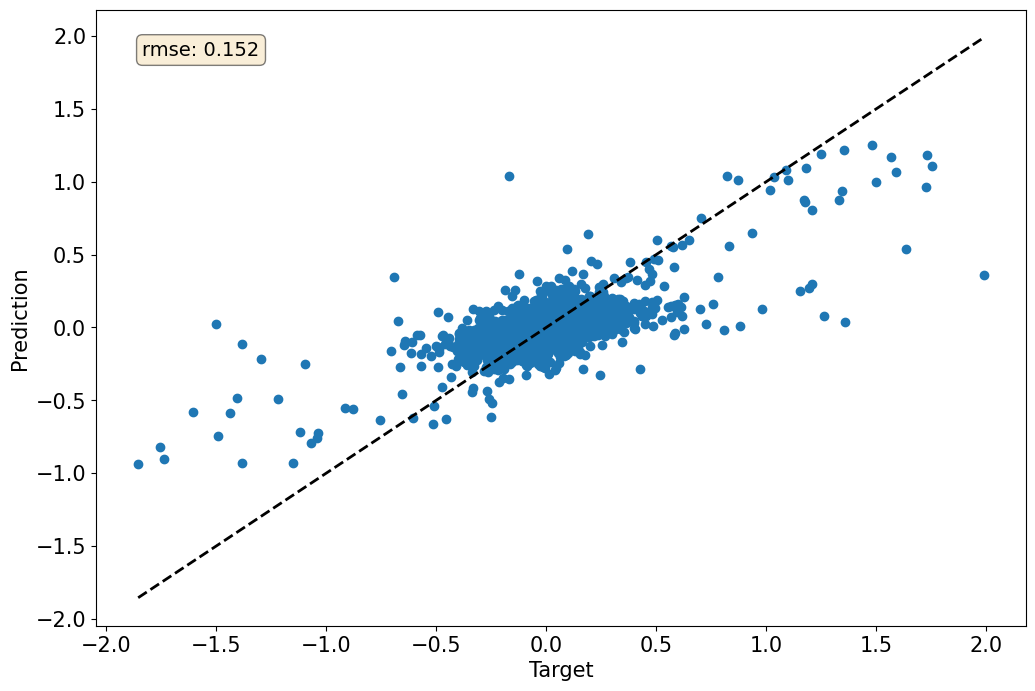

In [60]:
plt.scatter(y_test7, preds_reg)
textstr = 'rmse: ' + format(rmse_class_0, '.3g')
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)

# Add a diagonal line
min_value = min(y_test7.min(), preds_reg.min())
max_value = max(y_test7.max(), preds_reg.max())
plt.plot([min_value, max_value], [min_value, max_value], 'k--', lw=2)

plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.show()

### Plot regressor's SHAP values
Please note that the list below could change due to the random nature of the algorithm

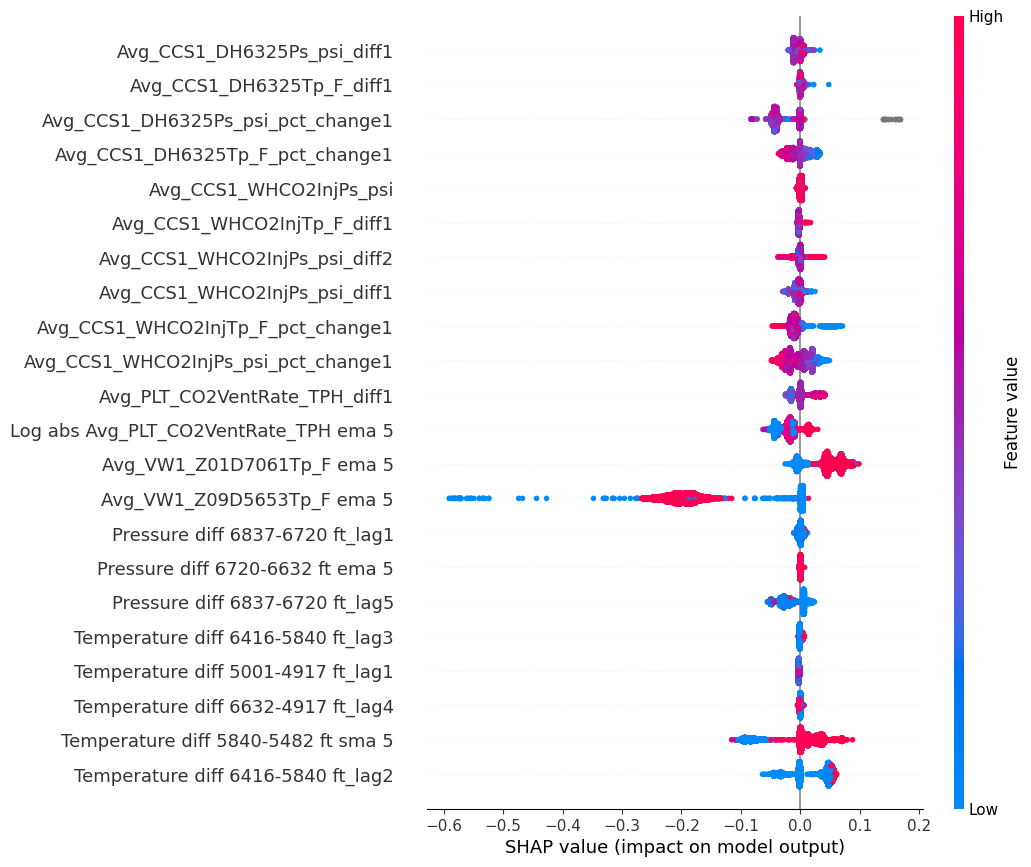

In [92]:
if plot_shap:
    # Reordering columns for the SHAP plot
    cols = [
        'Avg_CCS1_DH6325Ps_psi_diff1',
        'Avg_CCS1_DH6325Tp_F_diff1',
        'Avg_CCS1_DH6325Ps_psi_pct_change1',
        'Avg_CCS1_DH6325Tp_F_pct_change1',

        'Avg_CCS1_WHCO2InjPs_psi',
        'Avg_CCS1_WHCO2InjTp_F_diff1',
        'Avg_CCS1_WHCO2InjPs_psi_diff2',
        'Avg_CCS1_WHCO2InjPs_psi_diff1',
        'Avg_CCS1_WHCO2InjTp_F_pct_change1',
        'Avg_CCS1_WHCO2InjPs_psi_pct_change1',

        'Avg_PLT_CO2VentRate_TPH_diff1',
        'Log abs Avg_PLT_CO2VentRate_TPH ema 5',

        'Avg_VW1_Z01D7061Tp_F ema 5',
        'Avg_VW1_Z09D5653Tp_F ema 5',

        'Pressure diff 6837-6720 ft_lag1',
        'Pressure diff 6720-6632 ft ema 5',
        'Pressure diff 6837-6720 ft_lag5',
        'Temperature diff 6416-5840 ft_lag3',
        'Temperature diff 5001-4917 ft_lag1',
        'Temperature diff 6632-4917 ft_lag4',
        'Temperature diff 5840-5482 ft sma 5',
        'Temperature diff 6416-5840 ft_lag2'
    ]

    X_train7 = X_train7[cols]

    # Calculate shap values
    explainer = shap.TreeExplainer(low_values_reg)
    shap_values = explainer(X_train7)

    # Ordering the columns for the SHAP plot
    order = X_train7.columns
    col2num = {col: i for i, col in enumerate(X_train7)}
    order = list(map(col2num.get, order))

    # Plotting the SHAP values
    shap.plots.beeswarm(shap_values, max_display=len(cols), show=False, color_bar=True, order=order)
    plt.show()

### Retrain final regressor with 100% data

In [61]:
# Only keep data point classified as positive
y_train = df[df['Target > 2']==0]['Target']
x_train = df[df['Target > 2']==0][low_values_reg_top_K_feats]

dtrain = xgb.DMatrix(x_train, y_train)

if train:
    final_low_values_reg = xgb.train(low_values_best_hyperparams, dtrain, num_boost_round=int(low_values_opt_num_trees*1.09))
    final_low_values_reg.save_model(output_file+"regressor_class0/negative_class_xgb_final_regressor.json")
else:
    # Load pre-trained model
    final_low_values_reg = xgb.Booster()
    final_low_values_reg.load_model(output_file+"regressor_class0/negative_class_xgb_final_regressor.json")

# Section 5.6: Combining regressor's outputs in final validation set

In [107]:
# Extract the target variable from the dataset
y_train = df['Target']
# Extract date
train_dates = df['Date']
# Drop unnecessary columns and keep the feature matrix
x_train = df.drop(['Date', 'Target', 'Abs Target', 'Target > 2', 'Classifier output'], axis=1)

_, X_val_last15, _, y_val_last15 = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

# Removing first 5 rows of test set and corresponding labels due to lagged features
X_val_last15 = X_val_last15.iloc[5:]
y_val_last15 = y_val_last15.iloc[5:]

# Keeping last 15% of the train dataset predictions
y_pred_val = y_pred_train[-len(y_val_last15):]
# Extract last 15% of dates
train_dates = df['Date'].values[-len(y_val_last15):]

In [109]:
# Save indices to later reorder them
ones_indices = [i for i in range(len(y_pred_val)) if y_pred_val[i] == 1]
zeros_indices = [i for i in range(len(y_pred_val)) if y_pred_val[i] == 0]

In [110]:
preds_val15_class1 = spikes_reg.predict(xgb.DMatrix(X_val_last15.iloc[ones_indices][spikes_reg.feature_names]))
preds_val15_class0 = low_values_reg.predict(xgb.DMatrix(X_val_last15.iloc[zeros_indices][low_values_reg.feature_names]))

In [111]:
zeros_dict = {idx: val for idx, val in zip(zeros_indices, preds_val15_class0)}
ones_dict = {idx: val for idx, val in zip(ones_indices, preds_val15_class1)}

y_val15_predictions = []
for i in range(len(y_pred_val)):
    if y_pred_val[i] == 0:
        y_val15_predictions.append(zeros_dict[i])
    else:
        y_val15_predictions.append(ones_dict[i])

In [112]:
# Combined RMSE
rmse = np.sqrt(mean_squared_error(y_val_last15, y_val15_predictions))
rmse

1.2476356539004374

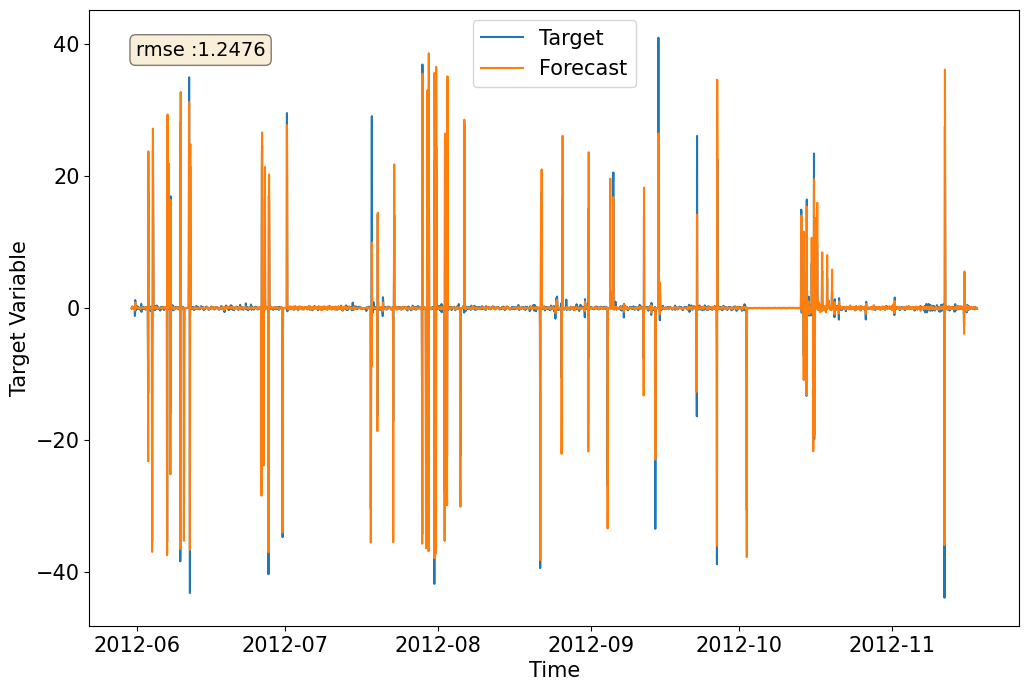

In [113]:
# plot the forecasted values against the real values
plt.plot(train_dates, y_val_last15, label='Target')
plt.plot(train_dates, y_val15_predictions, label='Forecast')

textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

# Section 7: Testing

In [62]:
# Load the dataset
df_test = pd.read_csv('./data/illinois_basing_test.csv')
# Rename target column
df_test = df_test.rename(columns={'inj_diff\xa0': 'Target', 'SampleTimeUTC': 'Date'})
df_test['Date'] = pd.to_datetime(df_test['Date'])
df_test = df_test.sort_values('Date')

# Impute
df_test['Avg_VW1_ANPs_psi'] = df_test['Avg_VW1_ANPs_psi'].fillna(method='ffill')
df_test.fillna(0, inplace=True)

# Drop feature with many null values
for col in df_test.columns:
    if '6945' in col:
        df_test = df_test.drop(col, axis=1)

In [63]:
x = df_test.drop(['Date'], axis=1)

x = utils.get_temperature_diff_depth(x)
x = utils.get_pressure_diff_depth(x)
x['Diff pressure downhole-wellhead'] = x['Avg_CCS1_DH6325Ps_psi'] - x['Avg_CCS1_ANPs_psi']
cols = x.columns
lagged_df = utils.create_lag_features(x, features=cols, n_lags=5)

# TO CREATE THE MORE EXTENDED FEATURE SET:
x = utils.create_abs_features(x, x.columns)
x = utils.create_trend_features(x, x.columns)

In [64]:
lagged_df.fillna(np.nan, inplace=True)
lagged_df = lagged_df.replace([np.inf, -np.inf], np.nan)
df_test = pd.concat([x, lagged_df], axis=1)

## 7.1 Predict test labels with classifier

In [65]:
# Make predictions on the test dataset using the trained model
y_pred_test = final_clf.predict(xgb.DMatrix(df_test[final_clf.feature_names]))
    
y_pred_test = (y_pred_test >= clf_best_threshold).astype(int)

In [66]:
# Save indices to later reorder them
ones_indices = [i for i in range(len(y_pred_test)) if y_pred_test[i] == 1]
zeros_indices = [i for i in range(len(y_pred_test)) if y_pred_test[i] == 0]

## 7.2 Predict positive labeled data points using spike regressor

In [67]:
reg_class1_pred = final_spikes_reg.predict(xgb.DMatrix(df_test.iloc[ones_indices][final_spikes_reg.feature_names]))

## 7.3 Predict negative labeled data points using the low-values regressor

In [69]:
reg_class0_pred = final_low_values_reg.predict(xgb.DMatrix(df_test.iloc[zeros_indices][final_low_values_reg.feature_names]))

## 7.4 Combining the results

In [70]:
zeros_dict = {idx: val for idx, val in zip(zeros_indices, reg_class0_pred)}
ones_dict = {idx: val for idx, val in zip(ones_indices, reg_class1_pred)}

y_test_predictions = []
for i in range(len(y_pred_test)):
    if y_pred_test[i] == 0:
        y_test_predictions.append(zeros_dict[i])
    else:
        y_test_predictions.append(ones_dict[i])

In [71]:
y_test_predictions[:5] = [0] * 5

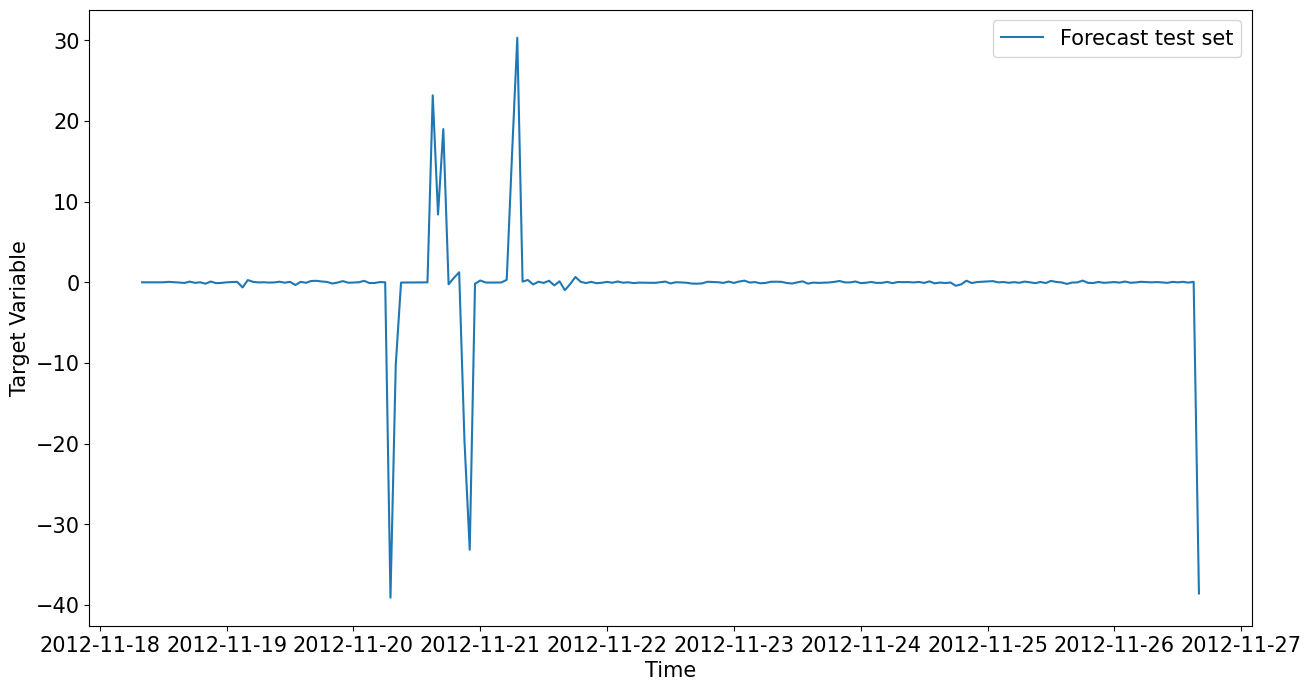

In [72]:
test = pd.read_csv('./data/illinois_basing_test.csv')

test['Predictions'] = y_test_predictions
test['SampleTimeUTC'] = pd.to_datetime(test['SampleTimeUTC'])
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 15})

# plot the forecasted values against the real values
plt.plot(test['SampleTimeUTC'], test['Predictions'], label='Forecast test set')

plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.legend()
plt.show()

In [73]:
test.rename(columns={'Predictions' : 'inj_diff'})['inj_diff'].to_csv(output_file+"y_test_predictions.csv",index=False)